In [16]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from data_swerick import create_dataset_swerick
from evaluation import evaluation_task
import preprocessing

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [3]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [7]:
#datasest
data_files = {"train": "swerick_data_train.pkl", "test": "swerick_data_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 104
    })
    test: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 26
    })
})


In [9]:
sample = swerick_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> protocle: {row['protocole']}'")
    print(f"'>>> Texte: {row['texte']}'")
    print(f"'>>> index: {row['__index_level_0__']}'")


'>>> protocle: 70'
'>>> Texte: RIKSDAGENS1956ANDRAKAMMARENNr717—22februariDebatterm.m.Fredagenden17februariSid.InterpellationavherrStenbergang.möjligheternaattstannasnabbgåendetågihändelseavstoppteckenvidbevakadejärnvägsöver-GÅDDAL1oomsejeraoyjesoda:om116IRSREBIRSRBENAFATSRARR:3Tisdagenden21februariInterpellationerav:fruSjöstrandang.rättfördem,somförtidspensioneratspågrundavsjukdomochinvaliditetattutnyttjabillighetsresornaförfolk-PENSlONÄLEI>.sendsieEdGKKkrMRcsRRsfVRSN6herrHagårdang.denuvarandetidernaförrusdrycksförsäljning..7herrEdströmang.vissamenligaföljderföraktiebolagochekonomiskaföreningar,sompågrundavmissuppfattningkommitatterläggaförlågtskattebeloppisambandmeddenår1955genomfördaskattehöjningen..........s..s..-soseorereretroera8Onsdagenden22februariSvarpåfrågorav:herrJohanssoniStockholmang.enbindandeförsäkrantilllöntagarnaomförhindrandeavallaeventuellalevnadskostnadsstegringarunderdentidrymd,som1956årsavtalsuppgörelseavser..10herrBraconierang.redogörelsefördeåtgärder,somvidtagi

In [8]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 104
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 26
    })
})

In [9]:
chunk_size = 128

In [12]:
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 14388'
'>>> Review 1 length: 137372'
'>>> Review 2 length: 104194'


In [10]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 57099
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 12421
    })
})

In [11]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

In [13]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = model_checkpoint.split("/")[-1]

trainer = preprocessing.create_trainer(model,model_name,batch_size,logging_steps,train_dataset=lm_datasets["train"],eval_dataset=lm_datasets["test"],data_collator=data_collator,tokenizer=tokenizer,num_epochs=100)

892


In [14]:
eval_results = trainer.evaluate()
print(eval_results)
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/195 [00:00<?, ?it/s]

{'eval_loss': 8.636436462402344, 'eval_runtime': 18.0329, 'eval_samples_per_second': 688.795, 'eval_steps_per_second': 10.814}
>>> Perplexity: 5633.22


In [18]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] RIKSDAGENS [MASK]6ANDRAKA [MASK]MARENNr717 — 22februariDebatterm. m. Fredagenden17fe [MASK]ariSid. InterpellationavherrStenbergang. [MASK]atts [MASK]nasnabbgåendetågihände [MASK]eavstopp [MASK]vid [MASK]adejärnvägs [MASK] -nomÅDDAL1 [MASK]sejeraoyjesoda : om116IRSREBI [MASK]SRBENAFA [MASK]RARR : [MASK]Tisdagenden [MASK]februariInterpellationerav :strandSjöstrandang. rättfördem, somförtidspensionerats'

'>>> [MASK]grunddesordning [MASK]ochinvaliditetattutnyttjabillighet [MASK]naförfolk - PENSlON [MASK] [MASK]I >. sends [MASK]E kriminGKK [MASK]M produktionscsRRsfVRSN6herrHagårdang. denuva [MASK]idernaförrusdrycksförsäljning.. 7herrEhäradtrömang. vissamenliga [MASK]erföraktiebolag repetkonomiskaföreningar, [UNK].......... s.. [MASK] [MASK]. - [MASK]seorereretroera8Onsdagenden22febru [MASK]frisörvararvagn Webbav : herrJohanssoniStockholmang'


trial with a manual implementation

In [17]:
print(lm_datasets)

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])


eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)

print(eval_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 57099
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 12421
    })
})


AttributeError: module 'preprocessing' has no attribute 'create_deterministic_eval_dataset'

In [20]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}


eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)

print(device)
for batch in train_dataloader:
    batch = to_device(batch)

for batch in eval_dataloader:
    batch = to_device(batch)




print(eval_dataloader.dataset)

cuda
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12421
})


In [21]:
print(train_dataloader.dataset)
print(eval_dataloader)

for batch in eval_dataloader:
    print(batch["input_ids"].device)
    break

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 57099
})
cpu


In [22]:
print(len(train_dataloader))

893


In [23]:
def get_dataloader():
    train =DataLoader(
    lm_dataset_bis["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator)
    train = [inputs.to(device) for inputs in train_dataloader]
    return train


for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break

for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break



##öjligheter [MASK]illmedinflytandeidestatligaföretagen? Ens [MASK]tjänstemantillsattes [MASK]någ [MASK]ånaderefterdet [MASK]herrSk [MASK]lämnatsinpost. [MASK]skulleemellertidtillut [MASK]spunktförmittegentligaan [MASK]viljataett [MASK]tannatyttrandeavherrSköld, [MASK]detyttrandehan [MASK]deidennakammare, dådenstoranykterhets [MASK]beslutades. DåsadeherrSköld — ipolemi [MASK]eddemsomvädraderagnarökochundergång Vie attdetfinnsbaraettvapen, [MASK]detär » denurgamla, envisakulturkampenattihärdigtfost [MASK]ochihärdigt
[MASK]somvarmedvid Fielddragningeniutskottet [MASK]funnit, attfråganblivitmycketnoggrantprövadhos [MASK]ungl. Maj [MASK] t. [MASK]föredrogsförs [MASK]srådenQuens [MASK]chBergquistpåsintid, innandenföredrogsförfinans [MASK]. Detfattasingentingif [MASK]gaomsk [MASK]ighetsbedömningen. [MASK]manskallsäganågonting [MASK]godellerondtr [MASK]etta [MASK], såärjuingentingbevisatomdetvargodellerondtro. Menlåtgåföra [MASK] [MASK] [MASK]godtro! Detkanjupåsinhöjd [MASK]förabef [MASK]


In [17]:
model_bis = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_bis=model_bis.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
model_bis.eval()

total_loss = 0.0  # Variable to accumulate total loss

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model_bis(**batch)
    loss = outputs.loss
    total_loss += loss.item()   # Accumulate the batch loss

# Calculate the average loss
average_loss = total_loss / len(eval_dataloader)

print(f"Initial Loss: {average_loss}")

Initial Loss: 2.088864606044014


In [23]:

optimizer = AdamW(model_bis.parameters(), lr=1.3e-5)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.3e-05
    maximize: False
    weight_decay: 0.01
)


In [24]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

  0%|          | 0/2682 [00:00<?, ?it/s]

cuda:0
0
losses_train [1.5493079758597168]
>>> Epoch 0: Perplexity: 3.823124535065952
losses_test [1.3400312946532584]
cuda:0
1
losses_train [1.5493079758597168, 1.3381776583008052]
>>> Epoch 1: Perplexity: 3.6909192260499224
losses_test [1.3400312946532584, 1.3048776941856153]
cuda:0
2
losses_train [1.5493079758597168, 1.3381776583008052, 1.2556872935903152]
>>> Epoch 2: Perplexity: 3.660984116582702
losses_test [1.3400312946532584, 1.3048776941856153, 1.296722845982779]
epoch 3


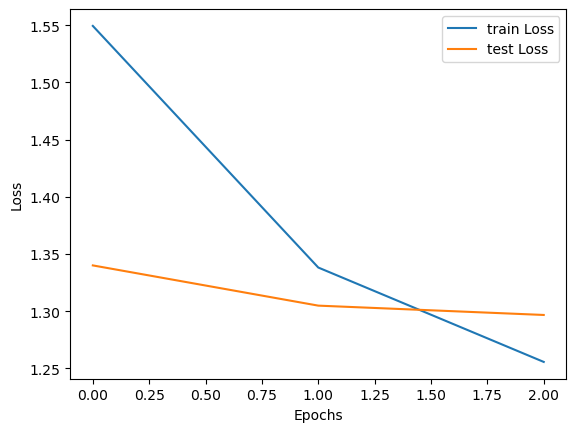

In [25]:
progress_bar = tqdm(range(num_training_steps))

losses_train=[]
losses_test=[]
#train_dataloader = get_dataloader()
for epoch in range(num_train_epochs):
    # Training
    model_bis.train()
    print(next(model_bis.parameters()).device)
    print(epoch)
    params_before_optimization = [param.data.clone() for param in model_bis.parameters()]
    total_loss_train = 0.0 
    train_dataloader = get_dataloader()

    for batch in train_dataloader:
        outputs = model_bis(**batch)
        loss = outputs.loss
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        params_after_optimization = [param.data for param in model_bis.parameters()]
        parameters_changed = any((param_before != param_after).any() for param_before, param_after in zip(params_before_optimization, params_after_optimization))
        #if parameters_changed==True :
             # print(parameters_changed) 
        progress_bar.update(1)

    losses_train.append(total_loss_train/len(train_dataloader))
    print("losses_train",losses_train)

    # Evaluation
    model_bis.eval()
    losses=[]
    total_loss_eval=0.0
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model_bis(**batch)

        loss = outputs.loss
        losses.append(loss.repeat(batch_size))
        total_loss_eval +=loss.item()


    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
       perplexity = float("inf")

    losses_test.append(total_loss_eval/len(eval_dataloader))


    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    print("losses_test",losses_test)

print("epoch",num_train_epochs)
plt.plot(range(num_train_epochs),losses_train,label="train Loss")

plt.plot(range(num_train_epochs),losses_test,label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

            

In [26]:
print(losses_train)
print(losses_test)

[1.5493079758597168, 1.3381776583008052, 1.2556872935903152]
[1.3400312946532584, 1.3048776941856153, 1.296722845982779]


In [27]:
file_path = "finetuning_manual"
model_bis.save_pretrained(file_path)
tokenizer.save_pretrained(file_path)

In [28]:
import pickle

file_name = "losses.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': losses_train, 'losses_test': losses_test}, f)


In [20]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model="./test_model")

In [23]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to(device)

In [24]:
model.get_input_embeddings()

Embedding(50325, 768, padding_idx=0)

In [ ]:
correct_predictions = 0
total_predictions =0
for step,batch in enumerate(train_dataloader):
    print(len(batch["input_ids"][0]))
    print(torch.sum(batch["labels"][0]!=-100))
    indices_tokens_masked = []
    for labels in batch["labels"]:
        indices_tokens_masked.append(torch.nonzero(labels !=-100).flatten().tolist())
    print(len(indices_tokens_masked[0]))
    output=model(**batch)
    predicted_token_ids = torch.argmax(output.logits,dim=-1)
    for i in range(batch_size):
        for j in indices_tokens_masked[i]:
            total_predictions +=1
            if batch["input_ids"][i][j] == predicted_token_ids[i][j]:
                correct_predictions += 1


    break
print("acuraccy :",correct_predictions/total_predictions)
        



128
tensor(20)
20
acuraccy : 0.10776942355889724


In [ ]:
correct_predictions = 0
total_predictions = 0

# Boucle sur les données d'entraînement
for step, batch in enumerate(eval_dataloader):
    # Récupération des indices des tokens masqués
    indices_tokens_masked = torch.nonzero(batch["labels"] != -100, as_tuple=False)

    # Calcul des prédictions
    output = model(**batch)
    predicted_token_ids = torch.argmax(output.logits, dim=-1)

    # Calcul du nombre de prédictions correctes
    correct_predictions += torch.sum(
        torch.eq(batch["input_ids"][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]], 
                 predicted_token_ids[indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]])
    ).item()
    
    # Mise à jour du nombre total de prédictions
    total_predictions += indices_tokens_masked.size(0)
    print(correct_predictions)
    

# Calcul de l'accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

In [25]:
for batch in eval_dataloader:
    print(batch["input_ids"].device)
    break

print(model.device)

cpu
cuda:0


In [28]:

model_hugging_face = AutoModelForMaskedLM.from_pretrained("./finetuning_trainer")
model_hugging_face=model_hugging_face.to(device)
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)
evaluation_task(model_hugging_face,eval_dataloader)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer evaluation....


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

>>> Perplexity: 290.05
Manual perplexity...
 Perplexity: 290.0474186353983
Accuracy...
Accuracy: 0.09923815637220537


In [29]:
logging_steps = 892
training_args = TrainingArguments(
        output_dir=f"{model.config.name_or_path}-finetuned-imdb",
        per_device_eval_batch_size=64,
        logging_steps=logging_steps,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        weight_decay=0.01,
        fp16=True,
        num_train_epochs=100
        )


trainer = Trainer(
    model=model_kb,
    args=training_args,
    eval_dataset=eval_dataloader.dataset
)
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")


  0%|          | 0/195 [00:00<?, ?it/s]

>>> Perplexity: 5791.76


In [30]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
    logging_steps=logging_steps,
    logging_dir='./logs', 
    num_train_epochs=num_epochs
)

trainer = Trainer(
    model=model_kb,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

892


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

>>> Perplexity: 5633.22


In [ ]:
model.save_pretrained("test_model")
tokenizer.save_pretrained("test_model")

('test_model/tokenizer_config.json',
 'test_model/special_tokens_map.json',
 'test_model/vocab.txt',
 'test_model/added_tokens.json',
 'test_model/tokenizer.json')

In [ ]:
model_bis= model_bis.to(device)

for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model_bis(**batch)
            print(outputs)

        loss = outputs.loss
        break

print

MaskedLMOutput(loss=tensor(2.6232, device='cuda:0'), logits=tensor([[[-5.0223,  0.4154, -2.3864,  ..., -5.5606, -5.0629, -3.4974],
         [-1.0954,  5.2599, -2.9556,  ..., -0.3960,  0.4373, -2.4896],
         [-2.0861,  3.8183, -2.9867,  ..., -1.2302, -0.5725, -3.9156],
         ...,
         [-4.2078,  2.9131, -4.2809,  ..., -6.2652, -5.9967, -4.9424],
         [-3.5717,  4.1178, -3.8137,  ..., -4.8439, -4.4711, -4.6256],
         [-4.9879,  2.6433, -3.5158,  ..., -6.4307, -5.5433, -5.3921]],

        [[-4.9761,  0.8089, -4.1323,  ..., -6.4497, -6.2214, -4.8968],
         [-7.1820,  1.2812, -3.5109,  ..., -7.9648, -8.6972, -7.4118],
         [-6.6850,  1.2384, -3.0593,  ..., -5.8302, -6.9683, -5.8527],
         ...,
         [-3.3623,  5.2395, -5.0848,  ..., -6.1524, -8.3089, -3.8851],
         [-2.9469,  2.2891, -3.9655,  ..., -5.7697, -7.3034, -4.8108],
         [-5.7061,  4.6384, -5.6518,  ..., -7.5657, -9.7660, -5.3895]],

        [[-3.9146, -0.2475, -3.7024,  ..., -8.0613, -5.8

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
outputs.keys()

odict_keys(['loss', 'logits'])